In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-09-08 14:07:51.374502: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 14:07:51.375932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 14:07:51.399848: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 14:07:51.400519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-08 14:07:51.786902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-08 13:08:09.277220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-08 13:08:09.277717: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler

my_file = "./cyclohexanone.MDE"

df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

# print(f"Dimensiunea inițială: {len(df)} rânduri")
# print(f"Numărul de step-uri unice: {df['Step'].nunique()}")

# Pentru a păstra toate datele din fiecare step, setează rows_per_group foarte mare
# sau folosește len(df) pentru a fi sigur că iei totul
# rows_per_group = len(df)  # sau poți pune 10000 dacă vrei o valoare fixă
# rows_per_group = 900
# rows_per_group = len(df)

# Fără grupare, folosim toate datele direct
df_data = df.copy()
df_data['pos_in_group'] = df_data.index  # Poziție simplă, fără grupare

print(f"Dimensiunea după filtrare: {len(df_data)} randuri")
print(f" Range E_tot: [{df_data['E_tot'].min():.6f}, {df_data['E_tot'].max():.6f}] eV")

# Scalare energie
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

print("\nPrimele 10 valori originale E_tot si scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))

Dimensiunea după filtrare: 6251 randuri
 Range E_tot: [-1580.726440, -1580.618050] eV

Primele 10 valori originale E_tot si scalate Energy_scaled:
        E_tot  Energy_scaled
0 -1580.63049       0.885229
1 -1580.62921       0.897038
2 -1580.62920       0.897131
3 -1580.62919       0.897223
4 -1580.62918       0.897315
5 -1580.62916       0.897500
6 -1580.62914       0.897684
7 -1580.62913       0.897777
8 -1580.62912       0.897869
9 -1580.62909       0.898146


In [3]:
# ## 2. Preprocesare Simplificată
from sklearn.preprocessing import RobustScaler
# %%
# Selectare doar coloanele necesare
features = ['T', 'E_KS', 'Vol', 'P']  # Features pentru predicție
target = 'E_tot'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# # Scalare
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

# X_scaled = scaler_X.fit_transform(X_data)
# y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

# Scalare cu RobustScaler pentru a gestiona posibili outlieri
scaler_X = RobustScaler()
scaler_y = RobustScaler()
X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completă")

Shape features: (6251, 4)
Shape target: (6251,)
Scalare completă


In [4]:
def create_sequences_multi_step(X, y, sequence_length, out_steps):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length - out_steps + 1):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length:i + sequence_length + out_steps])
    return np.array(sequences_X), np.array(sequences_y)

# Parametri
SEQUENCE_LENGTH = 150
OUT_STEPS = 5

X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (6097, 150, 4)
y shape: (6097, 5)


In [5]:
# Augmentare cu zgomot mic
noise_factor = 0.005  # Redus pentru a evita distorsionarea datelor
X_aug = X_seq + noise_factor * np.random.randn(*X_seq.shape)
y_aug = y_seq + noise_factor * np.random.randn(*y_seq.shape)
X_seq = np.concatenate([X_seq, X_aug])
y_seq = np.concatenate([y_seq, y_aug])

print(f"X shape după augmentare: {X_seq.shape}")
print(f"y shape după augmentare: {y_seq.shape}")

total_samples = len(X_seq)
train_size = int(total_samples * 0.8)   # 70% pentru antrenare
val_size = int(total_samples * 0.1)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


X shape după augmentare: (12194, 150, 4)
y shape după augmentare: (12194, 5)
Dimensiuni train: (9755, 150, 4), (9755, 5)
Dimensiuni val: (1219, 150, 4), (1219, 5)
Dimensiuni test: (1220, 150, 4), (1220, 5)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_optimized_lstm_model(input_shape, out_steps=5):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LSTM(32, return_sequences=False, dropout=0.2, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='mse',
        metrics=['mae']
    )
    return model

# Construiește modelul
model = build_optimized_lstm_model(input_shape=(SEQUENCE_LENGTH, len(features)), out_steps=OUT_STEPS)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150, 64)           17664     
                                                                 
 batch_normalization_2 (Batc  (None, 150, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 5)                

2025-09-08 14:29:34.080702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 14:29:34.081483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 14:29:34.081967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salvează modelul final (opțional, pe lângă ModelCheckpoint)
model.save('14_cyclohexanone_v4.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/100


2025-09-08 14:29:41.995897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 14:29:41.996746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 14:29:41.997297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

609/610 [============================>.] - ETA: 0s - loss: 0.2622 - mae: 0.2456

2025-09-08 14:30:05.356270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 14:30:05.357009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 14:30:05.357523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

610/610 [==============================] - 24s 37ms/step - loss: 0.2622 - mae: 0.2456 - val_loss: 0.1533 - val_mae: 0.1691 - lr: 3.0000e-04
Epoch 2/100
610/610 [==============================] - 22s 37ms/step - loss: 0.1583 - mae: 0.1637 - val_loss: 0.1187 - val_mae: 0.1310 - lr: 3.0000e-04
Epoch 3/100
610/610 [==============================] - 22s 36ms/step - loss: 0.1295 - mae: 0.1410 - val_loss: 0.1023 - val_mae: 0.1279 - lr: 3.0000e-04
Epoch 4/100
610/610 [==============================] - 23s 37ms/step - loss: 0.1093 - mae: 0.1297 - val_loss: 0.0954 - val_mae: 0.1362 - lr: 3.0000e-04
Epoch 5/100
610/610 [==============================] - 22s 36ms/step - loss: 0.0960 - mae: 0.1249 - val_loss: 0.0797 - val_mae: 0.1335 - lr: 3.0000e-04
Epoch 6/100
610/610 [==============================] - 22s 36ms/step - loss: 0.0813 - mae: 0.1156 - val_loss: 0.0759 - val_mae: 0.1426 - lr: 3.0000e-04
Epoch 7/100
610/610 [==============================] - 22s 36ms/step - loss: 0.0724 - mae: 0.1112 - 

In [13]:
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original.max() - y_test_original.min()))) * 100
print(f"   ├── MAPE: {mape:.2f}%")

   ├── MAPE: 2.80%


39/39 [==============================] - 0s 9ms/step
(1220, 5) (1220, 150, 4) (1220, 5)
(6100, 1) (6100, 1)


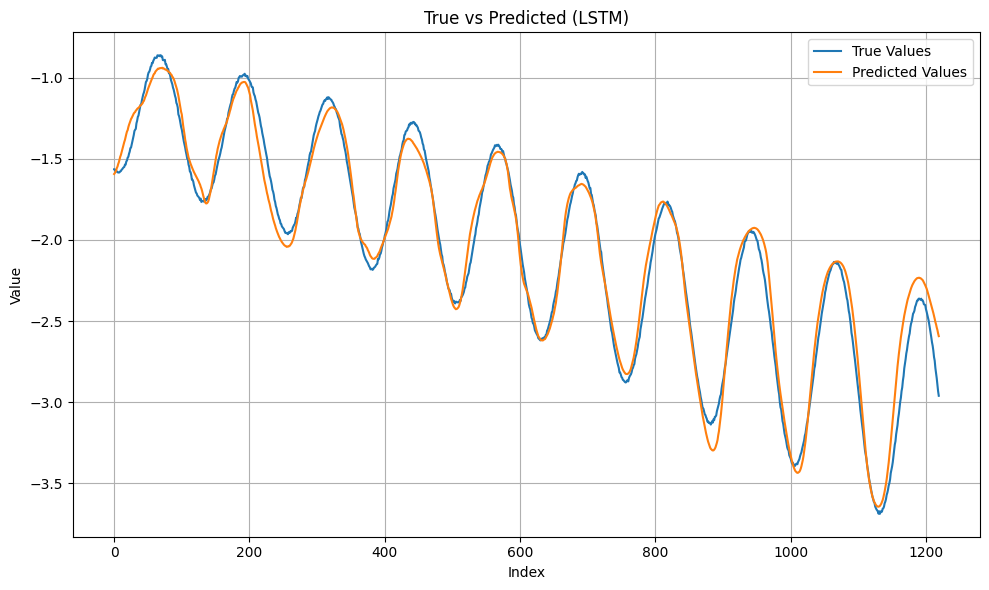

In [14]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastră
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.01075236
   ├── MAE: 0.07960106
   ├── RMSE: 0.10369360
   ├── MAPE: 4.13%
   └── R²: 0.976289 (97.63%)


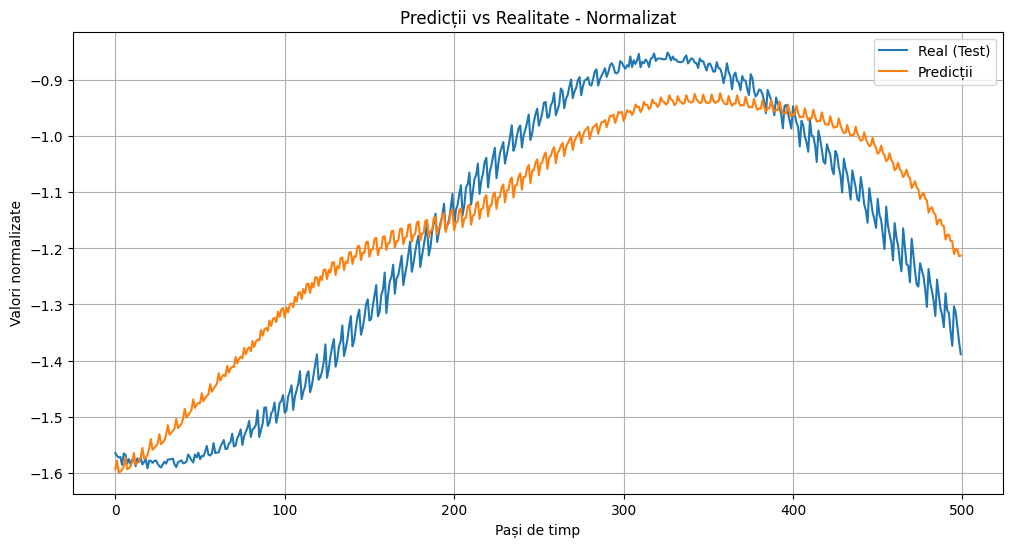

In [16]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"🏆 Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()
